In [34]:
library(mvtnorm)
library(tidyr)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




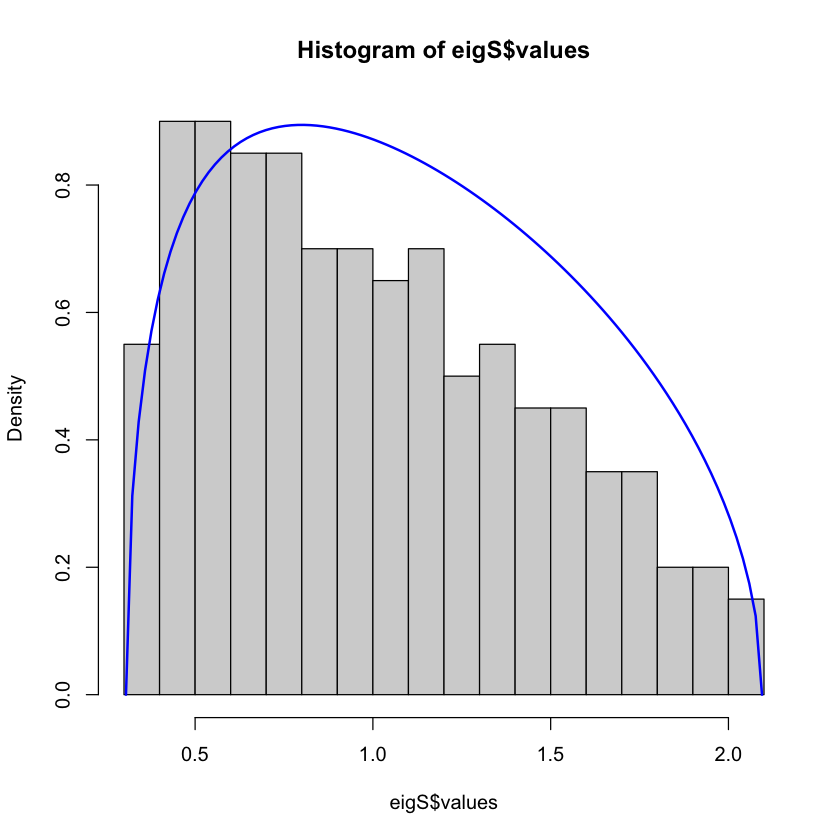

In [35]:
### [1] Sample Spectrum vs. Population spectrum
set.seed(10)

# we simulate data from the N_d(0, I_d) distribution --- all eigenvalues should
# be equal to one!

n <- 1000
d <- 200
# d / n = 0.2

X <- matrix(rnorm(n * d), nrow = n, ncol = d)

S <- crossprod(X) / n # assuming that the mean is known as zero, this is the sample covariance
eigS <- eigen(S)


#pdf("../fig/MP1.pdf")

hist(eigS$values, nclass = 20, prob = TRUE)
# theoretical distribution of the eigenvalues based on the Marchenko-Pastur law (MP law for short)
alpha <- 0.2 # d/n ratio
tmin <- (1 - sqrt(alpha))^2
tmax <- (1 + sqrt(alpha))^2
plot(function(t) sqrt((tmax - t)*(t - tmin)/t), add = TRUE, col = "blue", lwd = 2, from = tmin, to = tmax)
#dev.off()     

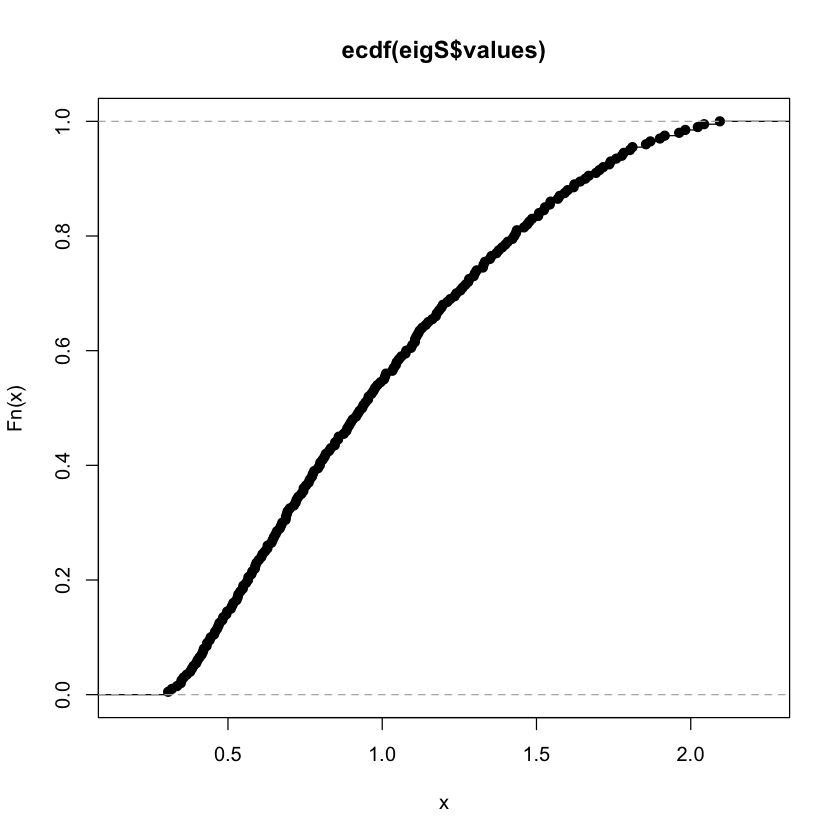

In [3]:
#pdf("../fig/MP2.pdf")
plot(ecdf(eigS$values))
#dev.off()

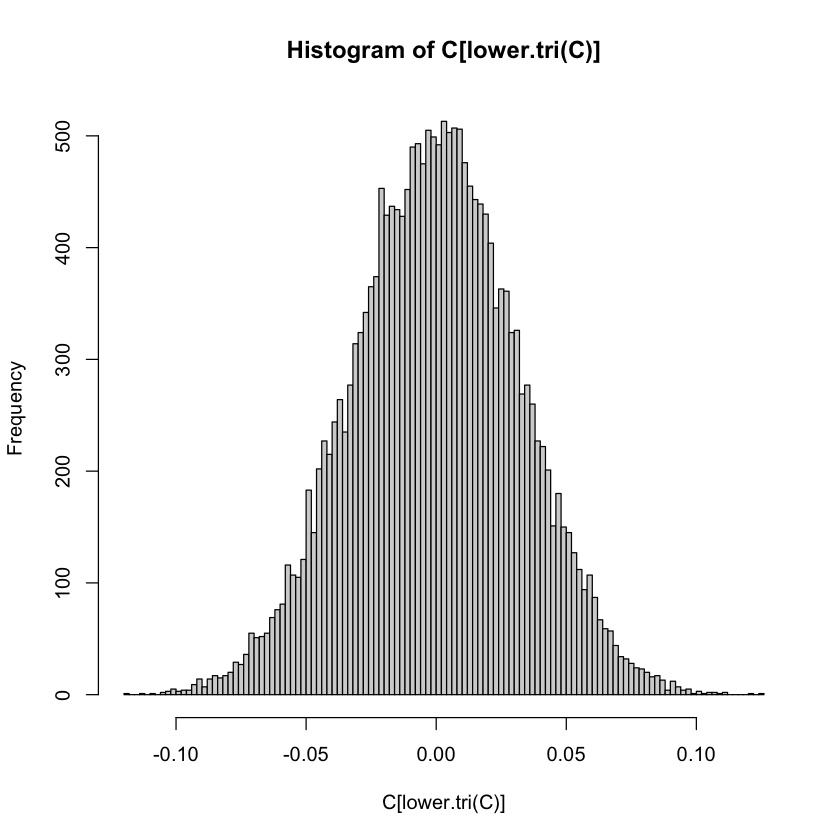

In [4]:
# distribution of correlations
C <- cov2cor(S)

#pdf("../fig/MP3.pdf")

hist(C[lower.tri(C)], nclass = 100)

#dev.off()

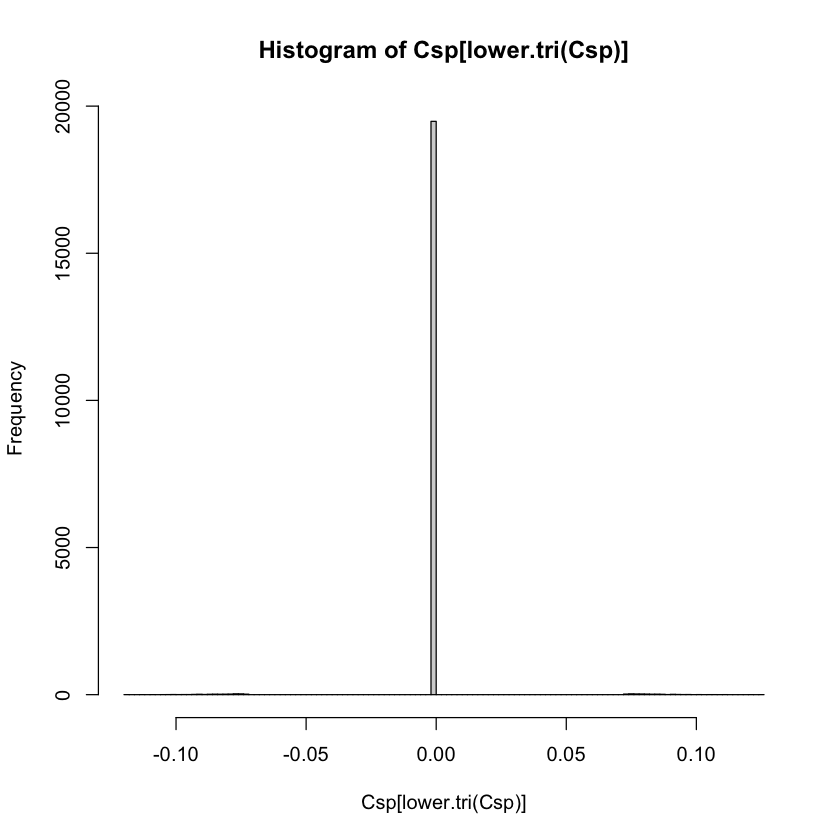

[1] 200

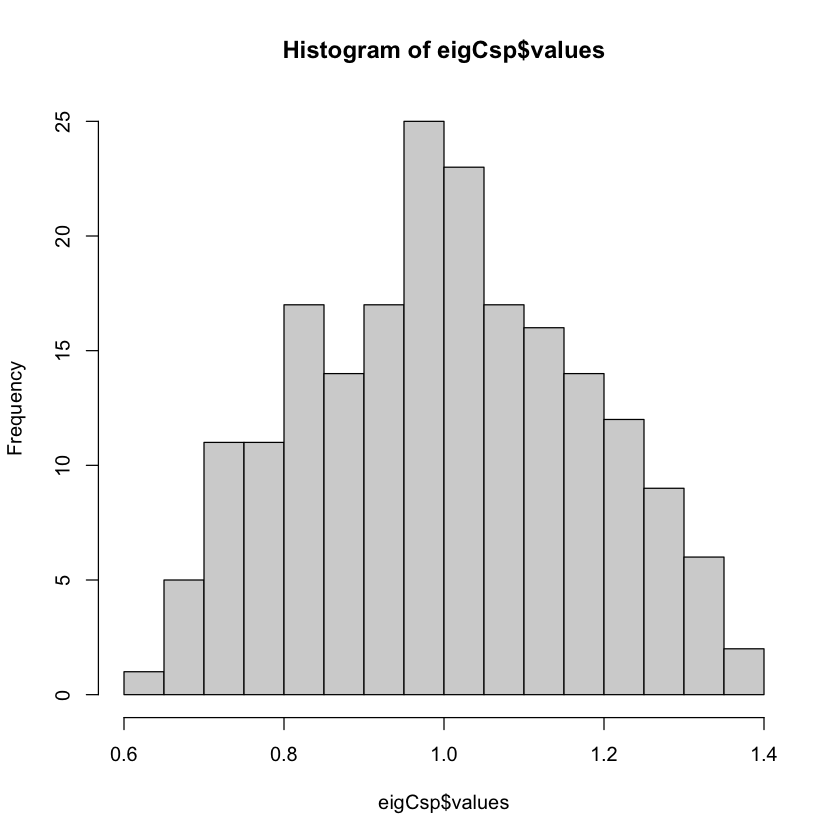

In [6]:
# Covariance thresholding

# choice of threshold (can be justified using theoretical arguments)
lambda <- sqrt(log(d)/n) # sqrt(2 * log(d)/n) ---> factor \sqrt{2} will achieve better performance

# thresholded correlation matrix
Csp <- C * (abs(C) > lambda)

# histogram of off-diagonal entries of the thresholded sample correlation matrix
hist(Csp[lower.tri(Csp)], nclass = 100)

# eigenvalue distribution of of the thresholded sample correlation matrix
eigCsp <- eigen(Csp)
hist(eigCsp$values, nclass = 20)

sum(eigCsp$values)

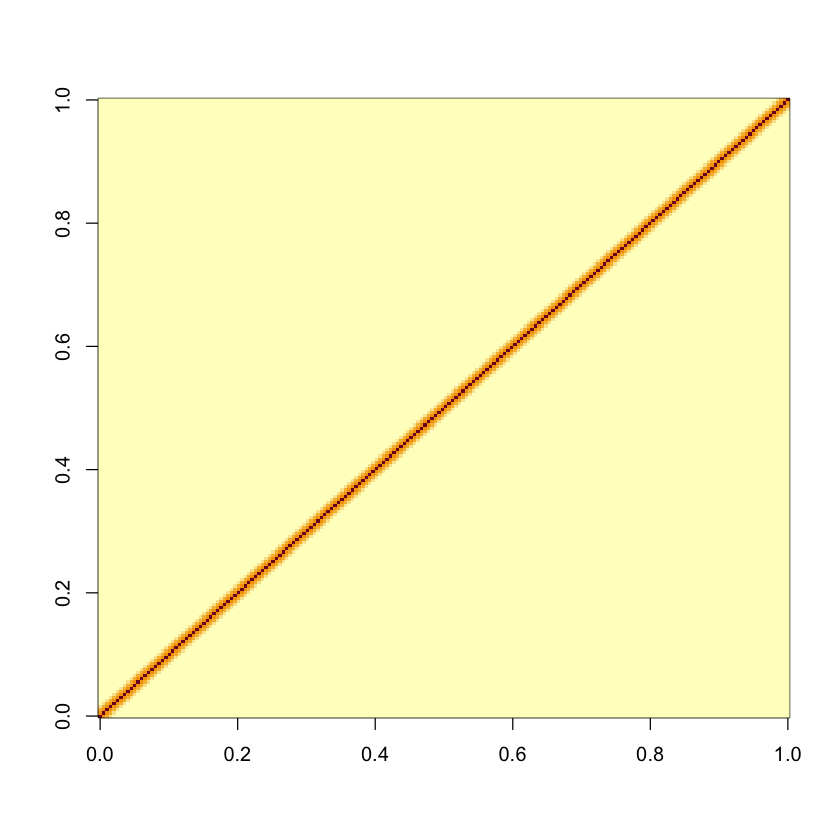

In [16]:
### [2] Banded covariance matrix estimation. Example: data from a Moving Average (MA) Process

# generate data from a moving average process (window 3)

rho <- c(0.5, 0.4, 0.2)
k <- 3
d <- 200

# here we fill the individual entries of the population covariance matrix
Sigma <- matrix(nrow = d, ncol = d, data = 0)
diag(Sigma) <- 1
for(j in 1:d){
    nleft  <- min(j - 1, k)
    nright <- min(d - j, k)

    if(nleft == 1)
        Sigma[j, j-1] <- rho[1]
    if(nleft == 2)
        Sigma[j,(j-2):(j-1)] <- c(rho[2], rho[1])
    if(nleft == 3)
        Sigma[j,(j-3):(j-1)] <- c(rho[3], rho[2], rho[1])

    if(nright == 1)
        Sigma[j,j+1] <- rho[1]
    if(nright == 2)
        Sigma[j,(j+1):(j+2)] <- c(rho[1], rho[2])
    if(nright == 3)
        Sigma[j,(j+1):(j+3)] <- c(rho[1], rho[2], rho[3])
}

eigSigma <- eigen(Sigma)$values
image(Sigma)

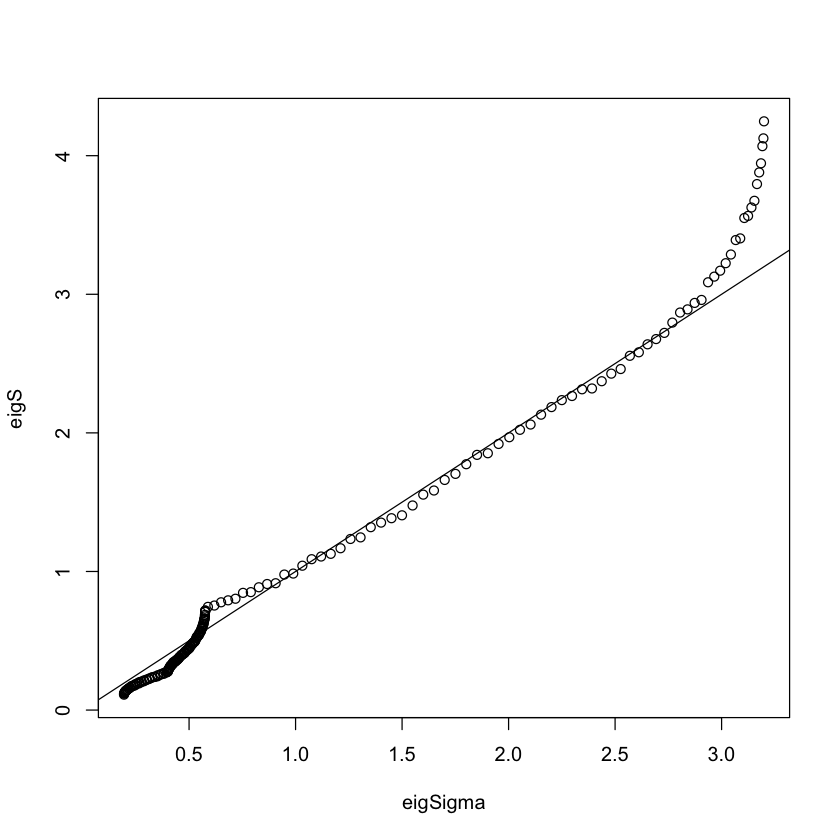

In [18]:
# generate data
X <- rmvnorm(n = n, sigma = Sigma)

# sample covariance matrix
S <- crossprod(X) / n
eigS <- eigen(S)$values

# theoretical vs.~empirical eigenvalues
qqplot(eigSigma, eigS)
abline(0,1)

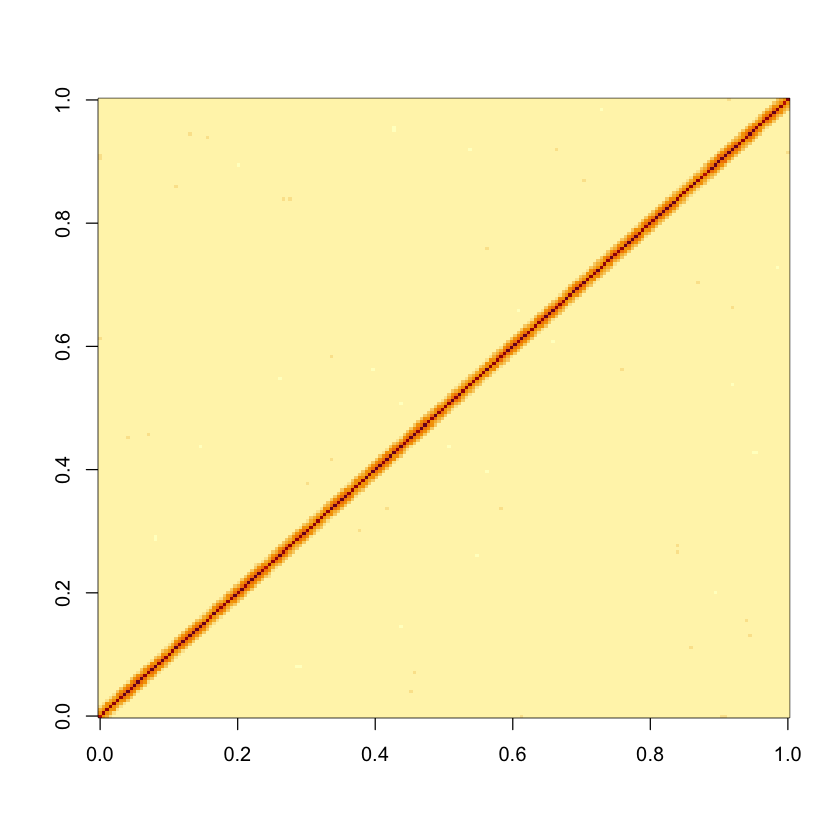

In [19]:
# thresholding estimator [here, we operate directly on S]
lambda <- sqrt(2 * log(d)/n)
Ssp <- S * (abs(S) > lambda)
image(Ssp)

[1] 1.550468

[1] 0.442305

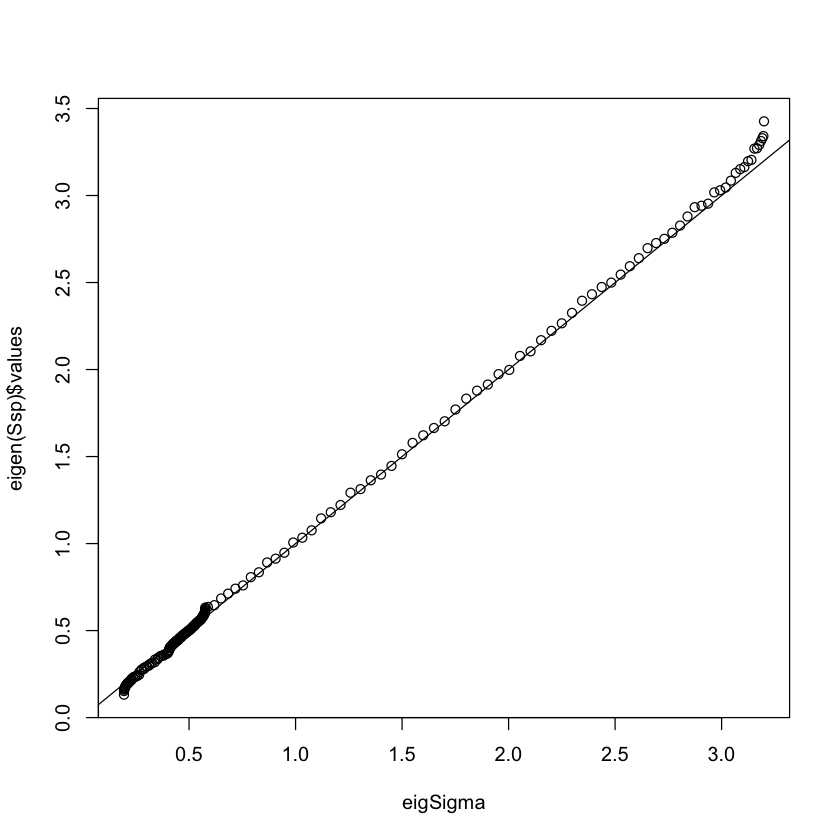

In [21]:
# operator norm error of the sample covariance matrix
max(abs(eigen(S - Sigma)$values))

# operator norm error of the thresholded covariance matrix
max(abs(eigen(Ssp - Sigma)$values)) #Ssp has significantly smaller error

# visual comparison of theoretical eigenvalues and eigenvalues in the thresholded estimator
qqplot(eigSigma, eigen(Ssp)$values) #spectrum significantly closer to actual spectrum
abline(0,1)

[1] 0.4156339

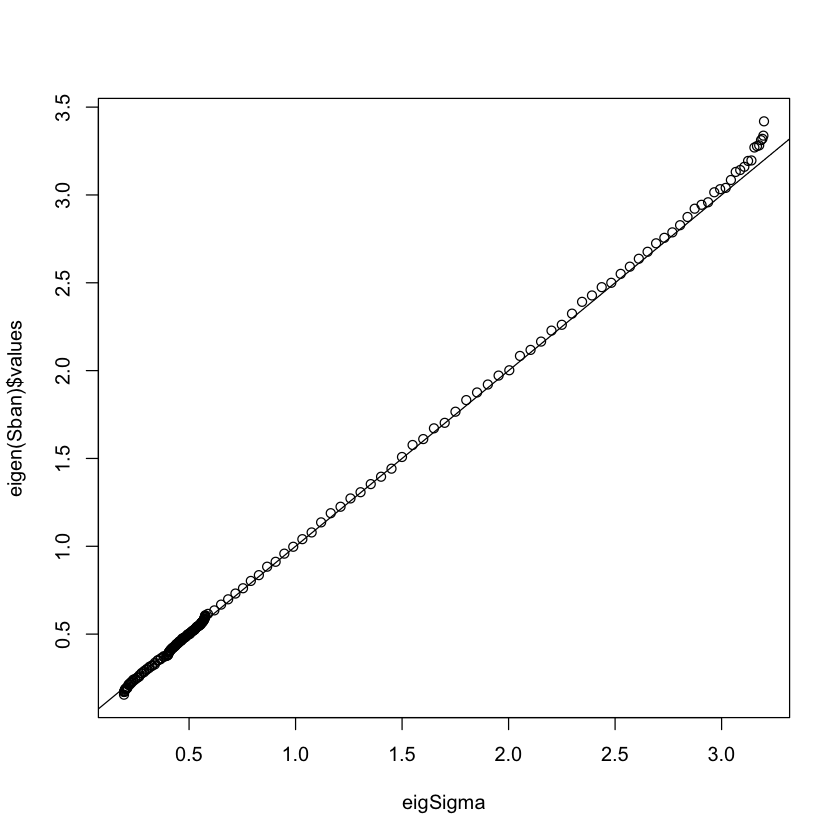

In [22]:
# banding estimator (assuming knowledge of the correct bandwidth)
Mask <- 1 * (abs(Sigma) > 0)

Sban <- S * Mask

max(abs(eigen(Sban - Sigma)$values)) # similar error as the thresholding estimator

qqplot(eigSigma, eigen(Sban)$values) # similar performance as before
abline(0,1)

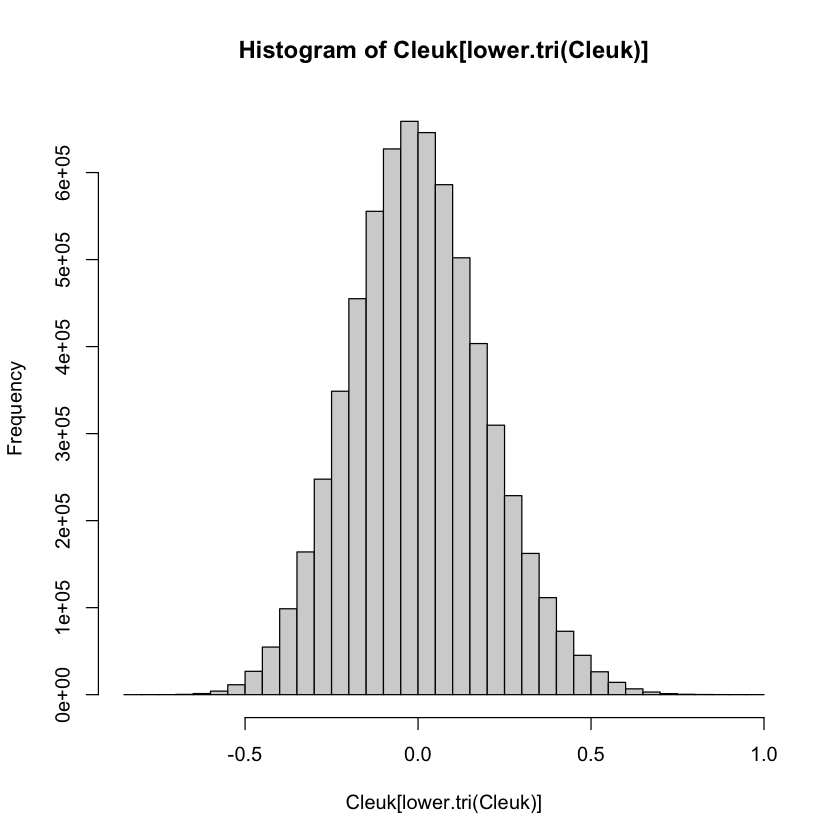

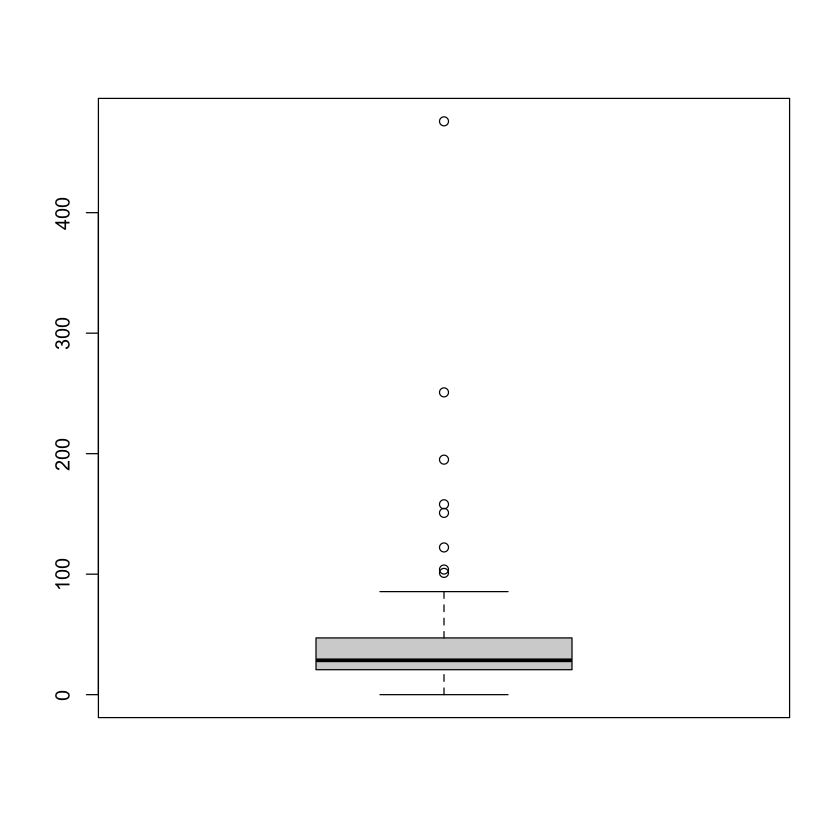

In [24]:
### real data 1: leukaemia data set (very high-dimensional)

leuk <- read.csv("../../data/leuk/leukemia_small.csv")
n <- ncol(leuk)
d <- nrow(leuk)
Cleuk <- cor(t(as.matrix(leuk)))
#image(Cleuk)
hist(Cleuk[lower.tri(Cleuk)], nclass = 50)
# thresholding appears reasonable --- correlations concentrated around zero
eigCleuk <- svd(scale(t(as.matrix(leuk)))/sqrt(n - 1))$d^2 # computation via SVD; note that most eigenvalues are zero since n << d
boxplot(eigCleuk)

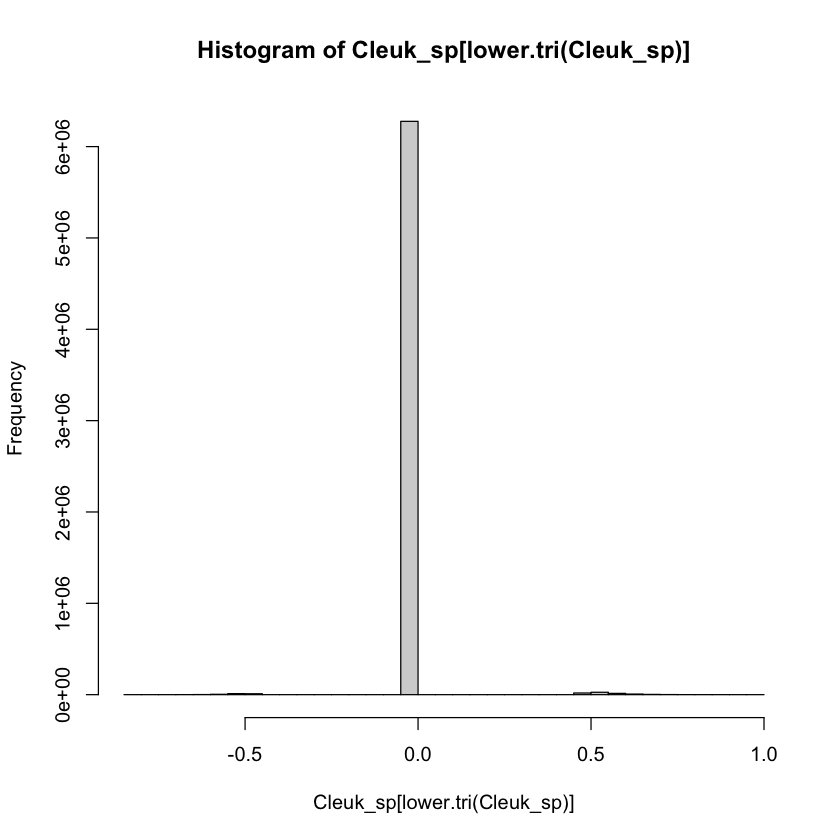

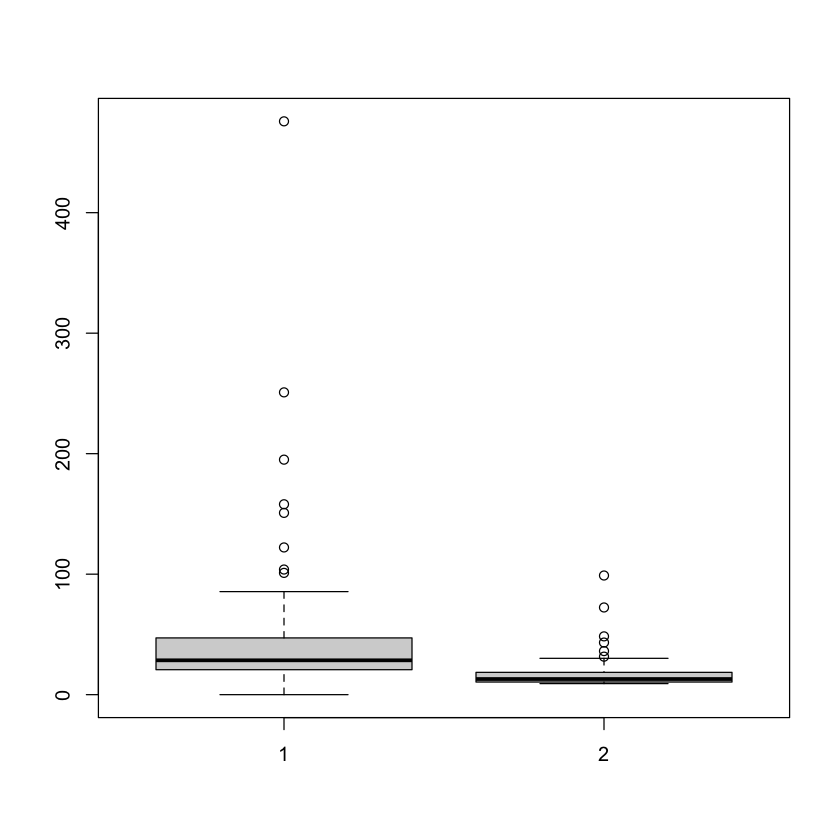

In [25]:
lambda <- sqrt(2 * log(d) / n)
Cleuk_sp <- Cleuk * (abs(Cleuk) > lambda)

hist(Cleuk_sp[lower.tri(Cleuk_sp)], nclass = 50)
eigCleuk_sp <- eigen(Cleuk_sp, only.values = TRUE)

#boxplot(eigCleuk_sp)
#qqplot(eigCleuk, eigCleuk_sp$values)
#abline(0,1)

# boxplot of eigenvalue distribution of raw and threholded correlation matrix
boxplot(cbind(eigCleuk[1:n], eigCleuk_sp$values[1:n]))

In [28]:
### real data 2: excerpt from Beijing Climate data

data_all <- readRDS("../../data/climate/data_all.rds")
# extract all data from weather station Nongzhanguan
dat_Nong <- data_all[data_all$station == "Nongzhanguan",]
rm(data_all)

In [67]:
# here, we analyze the variable "RAIN"
# we are interested in correlations within 24-hour windows (i.e., d = 24)
# for this purpose, we partition the data set by days (24-hr windows), and concatenate
# each 24-hr block vertically (i.e., one row = one 24-hr period, considered independently of each other -- of course, a simplifcation).

dates <- paste(dat_Nong$month, dat_Nong$day, dat_Nong$year, sep = "-")
dat_day <- dat_Nong %>% select(all_of(c("hour", "day", "month", "year", "RAIN")))
head(dat_day)    

,hour,day,month,year,RAIN
,<int>,<int>,<int>,<int>,<dbl>
222616,0,1,3,2013,0
222617,1,1,3,2013,0
222618,2,1,3,2013,0
222619,3,1,3,2013,0
222620,4,1,3,2013,0
222621,5,1,3,2013,0


In [68]:
dat_day_f <- dat_day %>%  pivot_wider(names_from = hour, values_from = RAIN) %>% drop_na()
dat_final <- dat_day_f %>% select(-all_of(c("day", "month", "year"))) %>% mutate(across(everything(), ~ log1p(.)))

In [69]:
# "benchmark": correlation matrix using the full data set 
Cfull <- cor(dat_final)
eigCfull <- eigen(Cfull)

# construct smaller data set by sub-sampling every 5th datum
train <- seq(from = 1, to = nrow(dat_final), by = 5)

# Stein loss for data-driven tuning parameter selection C_0: "target/reference", Chatinv: "inverse of 'comparison'" 
loss <- function(C0, Chatinv){
    d <- ncol(C0)
    sum(c(Chatinv) * c(C0))/d - (1/d) * determinant(Chatinv, log = TRUE)$modulus
}

# for reference: symmetrized Stein loss
#loss <- function(C0, Chat, Chatinv){
#    d <- ncol(C0)
#    C0inv <- solve(C0)
#    -sum(c(C0inv - Chatinv) * c(C0 - Chat))/(2 * d)
#}

# here we check the loss of the plain correlation matrix
dat_train <- dat_final[train,]
Ctrain <- cor(dat_train)
loss(Cfull, solve(Ctrain))

[1] 2.38531
attr(,"logarithm")
[1] TRUE

In [70]:
# next, we try *tapering* estimators (with triangular kernel, of varying bandwidth [the tuning parameter])
d <- ncol(Ctrain)

# we start fixed bandwidth bw = 10
bw <- 10
W <- (1 - (abs(outer(1:d, 1:d, "-"))/bw))
W <- W * (W >= 0)
Ctilde <- Ctrain * W
eigCtilde <- eigen(Ctilde)
pos <- eigCtilde$values >= 0.001
Chat <- eigCtilde$vectors[,pos] %*% diag(eigCtilde$values[pos])%*% t(eigCtilde$vectors[,pos])
Chatinv <- eigCtilde$vectors[,pos] %*% diag(1/eigCtilde$values[pos])%*% t(eigCtilde$vectors[,pos])
loss(Cfull, Chatinv) # note: significantly smaller loss 

[1] 0.5723425
attr(,"logarithm")
[1] TRUE

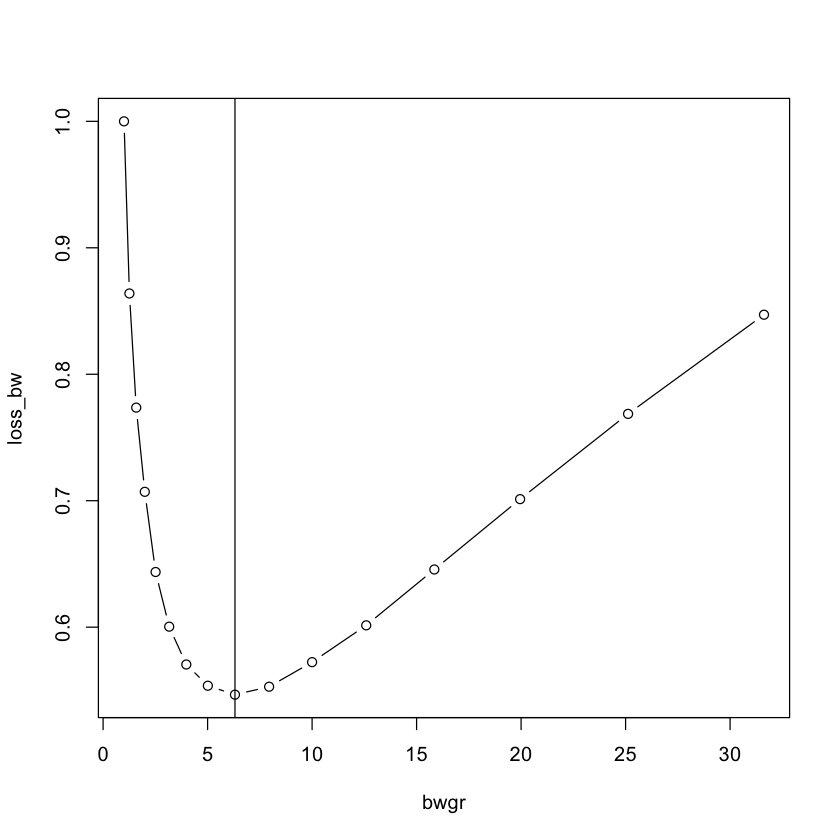

In [76]:
# plot 'cross-validation' trace
# NOTE: this is not exactly cross-validation here. In particular, there is overlap between
# training set and the full data set! 

bwgr <- 10^(seq(from = 0, to = 1.5, by = 0.1))
loss_bw <- numeric(length(bwgr))
for(k in 1:length(bwgr)){
    bw <- bwgr[k]
    W <- (1 - (abs(outer(1:d, 1:d, "-"))/bw))
    W <- W * (W >= 0)
    Chat <- Ctrain * W
    Chatinv <- solve(Chat)
    loss_bw[k] <- loss(Cfull, Chatinv)
}

plot(bwgr, loss_bw, type = "b")
# index achieving smallest looss
bestix <- which.min(loss_bw)
abline(v = bwgr[bestix])

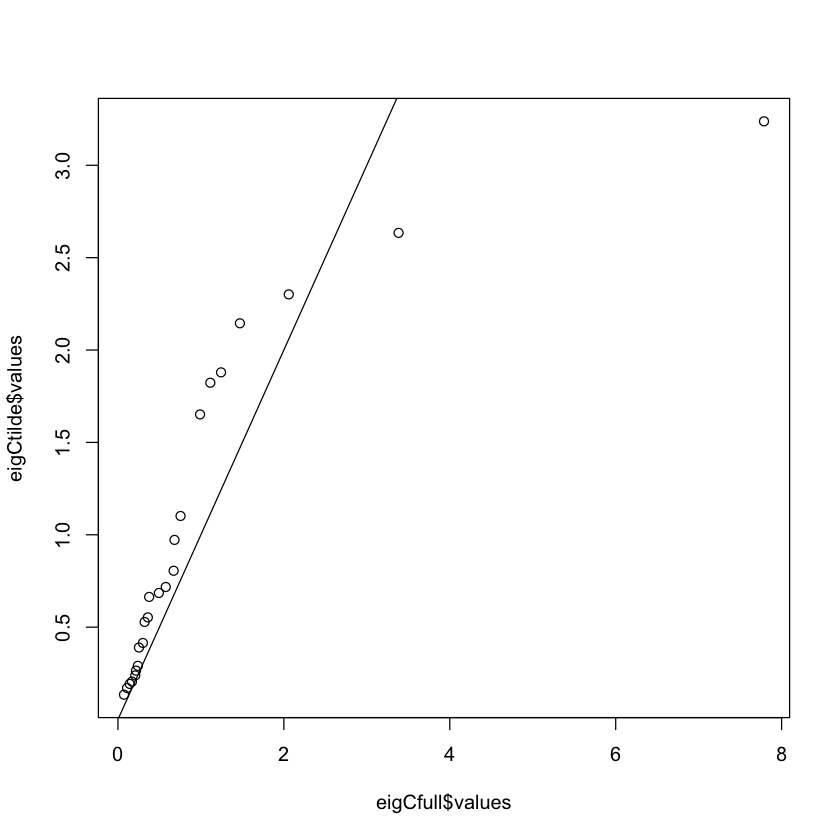

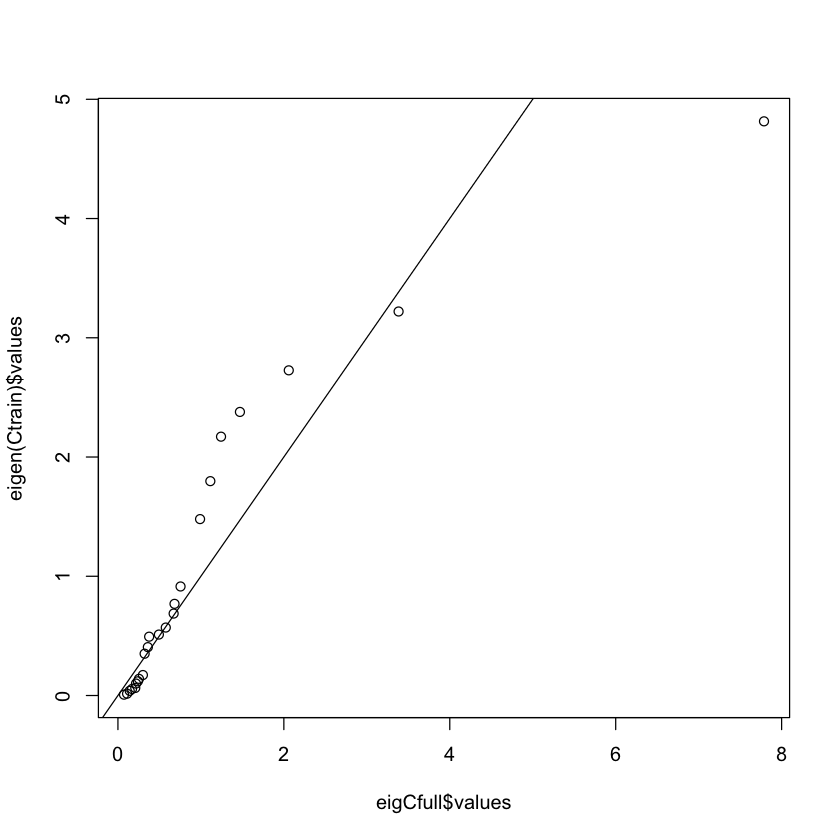

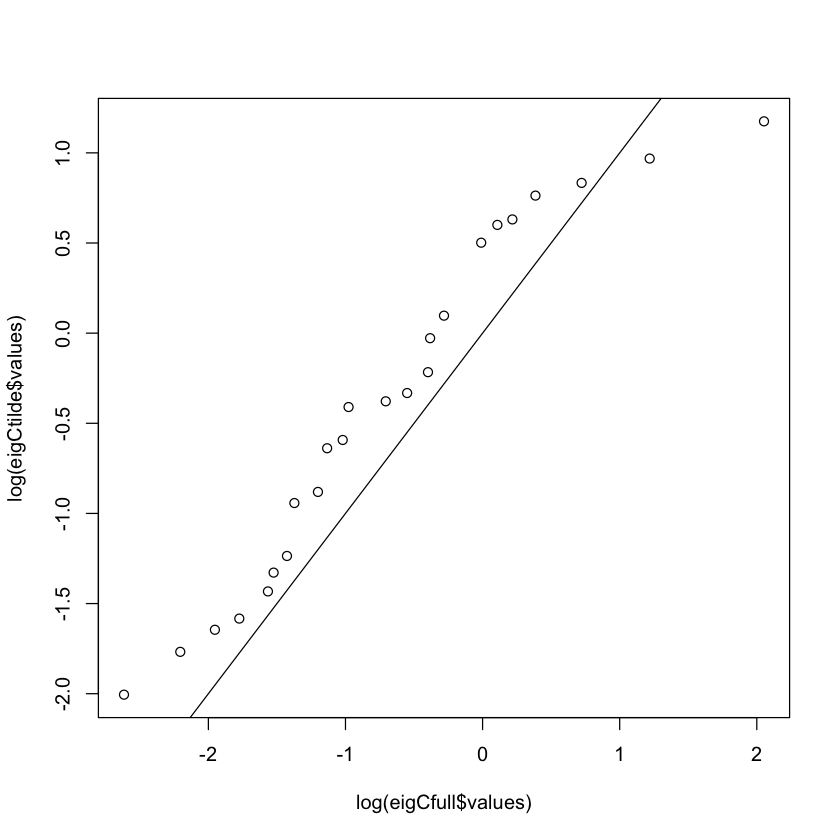

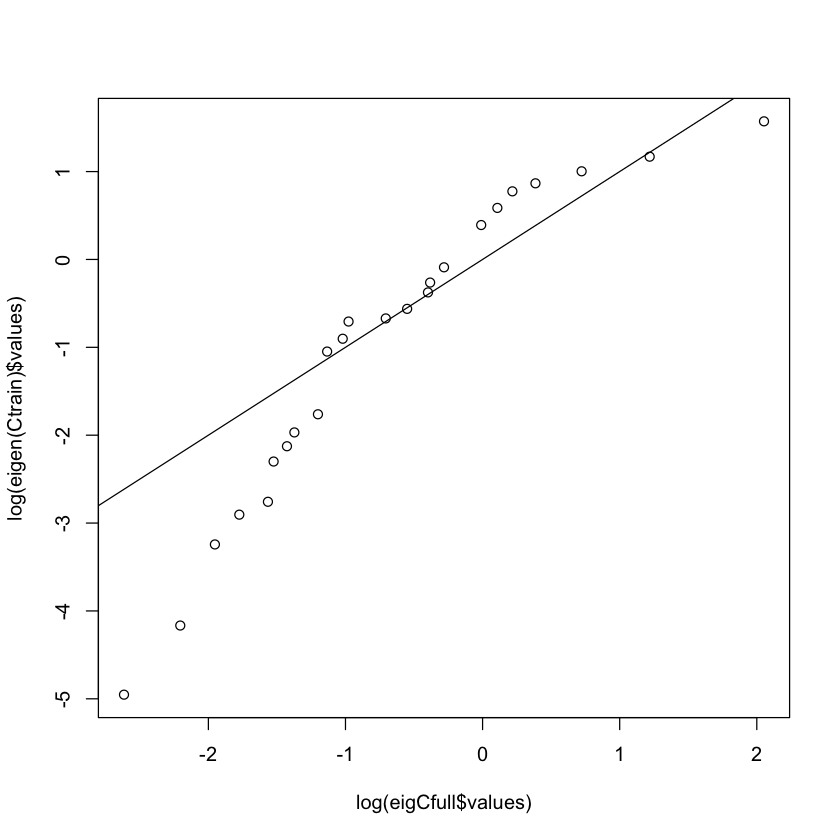

In [80]:
bw <- bwgr[bestix]
W <- (1 - (abs(outer(1:d, 1:d, "-"))/bw))
W <- W * (W >= 0)
Ctilde <- Ctrain * W
eigCtilde <- eigen(Ctilde)

# QQ-plots comparing eigenvalue distributions of the tapered and plain estimators to the reference (full data set)
qqplot(eigCfull$values, eigCtilde$values)
abline(0,1)
qqplot(eigCfull$values, eigen(Ctrain)$values)
abline(0,1)

# shows difference with small eigenvalues on log-scale
qqplot(log(eigCfull$values), log(eigCtilde$values))
abline(0,1)
qqplot(log(eigCfull$values), log(eigen(Ctrain)$values))
abline(0,1)